# Dynamic CAPM - Kalman Filter

Tsay - 11.3.1: CAPM with Time-Varying Coefficients

In [1]:
#import pandas_datareader.data as web

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import statsmodels.api as sm

tiingo_key = open('/Users/jenchiehcheng/tiingo/tiingo_key.txt').read()

start = datetime.datetime(2009, 12, 31)
end = datetime.datetime(2018, 2, 28)

%matplotlib inline

/Users/jenchiehcheng/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


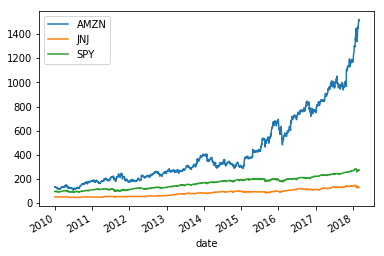

In [2]:
tickers = ['AMZN', 'JNJ', 'SPY']

px = pdr.DataReader(tickers, data_source='tiingo', start=start, end=end, access_key=tiingo_key)

close_px = pd.concat([px.loc[ticker, 'adjClose'] for ticker in tickers], axis=1)
close_px.columns = tickers

close_px.plot()

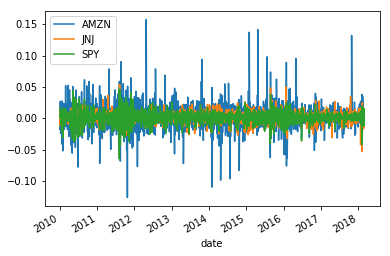

In [3]:
ret = close_px.pct_change()
ret.plot()

In [4]:
FF = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start, end=end)
FF[0] = FF[0] / 100
print(FF[0].columns)
rm = FF[0]['Mkt-RF']
rf = FF[0]['RF']

Index(['Mkt-RF', 'SMB', 'HML', 'RF'], dtype='object')


In [5]:
# excess returns
re = pd.concat([FF[0]] + [ret[ticker] - rf for ticker in tickers], axis=1)
re.columns = FF[0].columns.tolist() + tickers
re.dropna(inplace=True)
re.head()

,Mkt-RF,SMB,HML,RF,AMZN,JNJ,SPY
2010-01-04,0.0169,0.0058,0.0112,0.0,-0.004609,0.004192,0.016960
2010-01-05,0.0031,-0.0059,0.0122,0.0,0.005900,-0.011596,0.002647
2010-01-06,0.0013,-0.0025,0.0052,0.0,-0.018116,0.008134,0.000704
2010-01-07,0.0040,0.0008,0.0094,0.0,-0.017013,-0.007137,0.004221
2010-01-08,0.0033,0.0040,0.0001,0.0,0.027077,0.003438,0.003328


# KF



$$
\begin{align}
r_t &= \alpha_t + \beta_t r_{M, t} + e_t \\
\alpha_{t+1} &= \alpha_t + \eta_t \\
\beta_{t+1} &= \beta_t + \epsilon_t \\
\end{align}
$$

where $e_t \sim N(0, \sigma_e^2)$, $\eta_t \sim N(0, \sigma_\eta^2)$, and $\epsilon_t \sim N(0, \sigma_\epsilon^2)$. $(\sigma_e, \sigma_\eta, \sigma_\epsilon)$ is assumed to be known.

Measurement equation:
$$
r_t = 
\begin{bmatrix}
1 & r_{M, t}
\end{bmatrix}
\begin{bmatrix}
\alpha_t \\
\beta_t \\
\end{bmatrix}
+e_t
$$

State equation:
$$
\begin{bmatrix}
\alpha_{t+1} \\
\beta_{t+1} \\
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 \\
0 & 1\\
\end{bmatrix}
\begin{bmatrix}
\alpha_t \\
\beta_t \\
\end{bmatrix}
+
\begin{bmatrix}
\eta_t \\
\epsilon_t \\
\end{bmatrix}
$$

In [7]:
def generalized_KF_update(prev_S, prev_P, y, Z, sys_param):
    
    '''
    y: obervation values (r_t)
    Z: obervation model ([1, r_{1, t}, ..., r{k, t})
    '''
    
    state_trans = sys_param['SST'] # I_{1+k}
    Q = sys_param['Q'] # diag matrix
    H = sys_param['H'] # variance of r - (a + b*rm)
    
    # state prediction
    pred_S = state_trans.dot(prev_S)
    
    # prediction dispersion
    pred_P = state_trans.dot(prev_P).dot(state_trans.T) + Q
    
    # observation prediction
    pred_y = Z.dot(pred_S)
    
    # prediction error
    pred_err = y - pred_y
    
    # error dispersion
    F = Z.dot(pred_P).dot(Z.T) + H # assume 1 by 1
    
    # kalman gain
    G = pred_P.dot(Z.T) / F
    
    # state estimate
    est_S = pred_S + G.dot(pred_err)
    
    # dispersion estimate
    est_P = pred_P - G.dot(Z).dot(pred_P)
    
    return est_S, est_P

In [8]:
def generalized_KF(obs_val, obs_model, init_state, init_dispersion, sys_param):
    
    assert(obs_val.shape[0] == obs_model.shape[0])
    N = obs_val.shape[0]
    k = len(init_state)
    
    S = np.array(init_state).reshape(k, 1)
    P = np.array(init_dispersion).reshape(k, k)
    kf = np.array([init_state])
    
    o_val = obs_val.values
    o_model = obs_model.values
    
    for i in range(N):
        y = o_val[i]
        Z = o_model[i].reshape(1, k)
        
        S, P = generalized_KF_update(S, P, y, Z, sys_params)
        kf = np.r_[kf, S.T]
        
    return kf

In [9]:
def get_init_state_from_OLS(R, Rm, burn_len):
    
    k = Rm.shape[1] + 1
    res = sm.OLS(R.iloc[:burn_len], sm.add_constant(Rm.iloc[:burn_len, :])).fit(cov_type='HC0')
    
    S = res.params
    P = np.zeros((k, k))
    
    sys_params = dict()
    sys_params['H'] = res.mse_model,
    sys_params['Q'] = np.diag(res.HC0_se.values)
    sys_params['SST'] = np.eye(k)

    return S, P, sys_params

In [10]:
N = 100

S, P, sys_params = get_init_state_from_OLS(re['JNJ'], re[['Mkt-RF', 'SMB', 'HML']], N)

S_ = generalized_KF(re['JNJ'][N:] , sm.add_constant(re[['Mkt-RF', 'SMB', 'HML']][N:]), S, P, sys_params)

KF = pd.DataFrame(S_, columns=['alpha'] + ['Mkt-RF', 'SMB', 'HML'], index=re.index[N-1:])
#KF['beta'].plot()

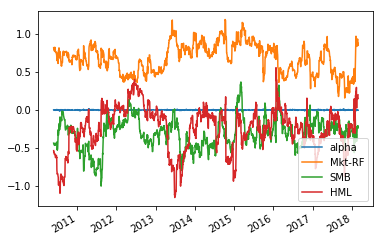

In [11]:
KF.plot()

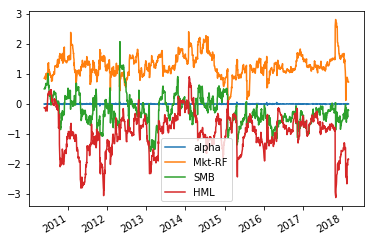

In [12]:
N = 100

S, P, sys_params = get_init_state_from_OLS(re['AMZN'], re[['Mkt-RF', 'SMB', 'HML']], N)

S_ = generalized_KF(re['AMZN'][N:] , sm.add_constant(re[['Mkt-RF', 'SMB', 'HML']][N:]), S, P, sys_params)

KF = pd.DataFrame(S_, columns=['alpha'] + ['Mkt-RF', 'SMB', 'HML'], index=re.index[N-1:])
KF.plot()

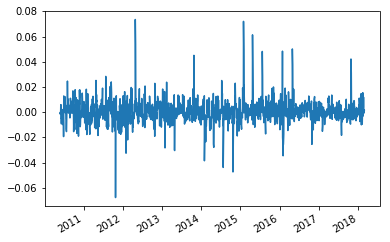

In [13]:
KF.alpha.plot()

In [14]:
#re_rolling = re.rolling(30)

rolling_res = [np.array([a_0, b_0])]
for i in range(re.shape[0] - N): #re.iloc[N:, :].iterrows():
    
    #print(df)
    
    rolling_df = re.iloc[N+i-100:N+i, :]
    
    df_res = OLS_CAPM(rolling_df['AMZN'], rolling_df['Mkt'])
    rolling_res.append(df_res.params.values)

NameError: name 'a_0' is not defined

In [15]:
rolling = pd.DataFrame(np.array(rolling_res), columns=['alpha', 'beta'], index=re.index[N-1:])

NameError: name 'rolling_res' is not defined

In [ ]:
KF['beta'].plot()
rolling['beta'].plot()